In [1]:
from edc import print_info
print_info("usecase-ndvi")


***Notebook Title***  
EDC NDVI Use-case

***Notebook Description***  
Euro Data Cube Use-case 01: NDVI


***Notebook Dependencies***  
This notebook requires an active subscription to:
* EDC Sentinel Hub


In [2]:
from edc import check_compatibility
check_compatibility("user-2022.10-14", dependencies=["SH"])



---------

The following environment variables are available:

* `SH_CLIENT_ID`, `SH_INSTANCE_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`


# NDSI timeline

This notebook presents an example on how a user can exploit the xcube client library to access and analyse data served via Euro Data Cube service API.

Thematically, this notebook illustrates how to generate a timeline of NDVI values calculated from Sentinel-2 bands. The normalized difference vegetation index (NDVI) is a simple graphical indicator that can be used to analyze remote sensing measurements acquired by a space platform, assessing whether or not the target being observed contains live green vegetation.

It demonstrates how xcube tools and Euro Data Cube complement each other. While Euro Data Cube services are used to access the data, xcube tools are utilized for analysis and visualization.

Specifically, following actions are demonstrated by this notebook:
1. Defining a new data cube for a given time range, region, and spatial resolution. 
2. Adding a new data layer to cube - calculated value of NDVI
3. Filling the cube with the data: requesting satellite imagery and calcualting NDVI layer
4. Displaying imageries, time series and linear plots for selected bands, area-of-interest and time

#### Importing dependancies
The user needs to first import the dependancies.

In [3]:
# xcube_sh imports
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers
from xcube_sh.viewer import ViewerServer

# xcube imports
from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.geom import clip_dataset_by_geometry
from xcube.core.evaluate import evaluate_dataset

# Various utilities
import json
from datetime import date, timedelta, datetime
import xarray as xr
import shapely.geometry
import IPython.display
import zarr
import numpy as np

import pandas as pd
import geopandas as gpd

To present the timeline of NDVI values, you will need to create a linear chart. 
 
To create the chart, it´s neccessary to import the Matplot library (matplotlib) first. The matplotlib is a plotting library which renders the plots.

In [4]:
import matplotlib.pyplot as plt

#### Specification of a geographical area of interest
The next step is to specify the area of interest - i.e. a geographical area, which the cube should cover and for which the NDVI will be calculated. 

The area of interest is specified via bounding box. You have to specify geographical coordinates of each corner of this bounding box.

For this demo, we are focussing on small coastal area near Kiel in Northern Germany (Baltic Sea).

In [5]:
x1 = 11.012421
y1 = 46.659805
x2 = 11.505432
y2 = 47.009289

In [6]:
bbox = x1, y1, x2, y2

 #### Visualisation of area of interest
 To check whether the area of interest has been specified correctly, you can integrate a simple map allowing visualisation of this area.

Visualize the bounding box.

In [7]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

 #### Setting the spatial resolution of the cube
 The next step is to specify the spatial resolution (pixel size) on which the raster data (in this case Sentinel-2 imageries) should be resampled and stored in.
 
In this case, the desired resolution is roughly 10 meters per pixel:


In [8]:
spatial_res = 0.00018   # = 10.038 meters in degree>

#### Getting the metadata of the collection we want to use
Get the metadata of the collection we want to load. We need this information to make correct choices when subsetting our data, e.g., band names, spatial and temporal extents etc.

In [9]:
#Get metadata of collection S2L2A

#### Configuring the data content of the cube
Now we specify the properties of our cube. 
First, the satellite and processing level of data to be integrated is specified. In this case, the Sentinel-2 Level 2A data will be used.

In the second row, the spectral bands are selected, which should be integarated. As we need to calculate NDVI index, we will need red and NIR bands (B04 and B08 of Sentinel-2).

Also, the time range and time period of the cube is specified in this step. In this case, we will be interested in data acquired between 14.5. and 31.7. 2018. A custom days time period will be used.

In [10]:
start_date = date(2018, 2, 1)
end_date = date(2018, 7, 1)
bands = ['B02', 'B03', 'B04', 'B11', 'CLM'] # how to get metadata of the cube
time_period = '5D'
#time_range = [(end_date - timedelta(days=days)).strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")]
time_range = [start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")]
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=bands,
                         tile_size=[512, 512],
                         bbox=bbox,
                         spatial_res=spatial_res,
                         time_range=time_range,
                         time_period=time_period)

#### Defining a "request collector"
We define a `request_collector` as an observer for SentinelHub (SH) requests made, so we can show SH usage statistics. 

In [11]:
request_collector = Observers.request_collector()

#### Loading data into the cube

Now, when the cube is correctly specified, we can open it. A lazy loading technique is used - it means that the data is loaded to the cube only when we actually use it (for some calcualtion, vizualization etc.). 

In [12]:
cube = open_cube(cube_config, observer=request_collector)

#### Verifying the content of the cube
Once the cube is opened, we can check whether it has been created in accordance with our expectations. 

The Cube Dataset information can be displayed, enabling to verify that the cube is specified correctly.

In [13]:
cube

<xarray.Dataset>
Dimensions:    (time: 31, lat: 2048, lon: 3072, bnds: 2)
Coordinates:
  * lat        (lat) float64 47.03 47.03 47.03 47.03 ... 46.66 46.66 46.66 46.66
  * lon        (lon) float64 11.01 11.01 11.01 11.01 ... 11.56 11.56 11.57 11.57
  * time       (time) datetime64[ns] 2018-02-03T12:00:00 ... 2018-07-03T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B02        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CLM        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2023-02-07T08:01:44.797917
    time_coverage_start:       2018-02-01T00:00:00+00:00
    time_coverage_end:         2018-07-06T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P5DT0H0M0S
    geospatial_lon_min:        11.012421
    geospatial_lat_min:        46.659805
    geospatial_lon_max:        11.565381
    geospatial_lat_max:        47.028445
    processing_level:          L2A

No requests have been made yet. Requests are made only if data is actually required.

  
#### Displaying information on specific band in the cube
It is possible to check each band loaded into the cube separately. In this case, we will check the band 04 (RED) and then band 08 (NIR)


In [14]:
cube.B11

<xarray.DataArray 'B11' (time: 31, lat: 2048, lon: 3072)>
dask.array<open_dataset-ce747d59fb3febfce5482452df12d681B11, shape=(31, 2048, 3072), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.03 47.03 47.03 47.03 ... 46.66 46.66 46.66 46.66
  * lon      (lon) float64 11.01 11.01 11.01 11.01 ... 11.56 11.56 11.57 11.57
  * time     (time) datetime64[ns] 2018-02-03T12:00:00 ... 2018-07-03T12:00:00
Attributes:
    sample_type:   FLOAT32
    units:         reflectance
    wavelength:    1612.05
    wavelength_a:  1613.7
    wavelength_b:  1610.4
    bandwidth:     92.5
    bandwidth_a:   91
    bandwidth_b:   94
    resolution:    20

  
#### Displaying values for each time step in the time serie (band 04)
Once the cube is built and time serie generated, we can display the spectral values for each time step of the serie. 

For this example we'll select a point at latitude=54.40, longitude=10.1 inside our area of interest (or geographical extent of the cube).

In this case, the nearest-neighbor interpolation methods is used by xcube. Nearest neighbour interpolation is the simplest approach to interpolation. This method simply determines the “nearest” neighbouring pixel, and assumes the intensity value of it.


In [15]:
timeseriesB03 = cube.B03.sel(lat=46.659805, lon=11.012421, method='nearest').to_series() # to_series() will actually query the data
timeseriesB03

time
2018-02-03 12:00:00    0.3283
2018-02-08 12:00:00    0.0001
2018-02-13 12:00:00    0.0166
2018-02-18 12:00:00    0.3650
2018-02-23 12:00:00    0.0749
2018-02-28 12:00:00    0.0332
2018-03-05 12:00:00    0.2440
2018-03-10 12:00:00    0.2736
2018-03-15 12:00:00    0.2649
2018-03-20 12:00:00    0.0518
2018-03-25 12:00:00    0.0426
2018-03-30 12:00:00    0.7968
2018-04-04 12:00:00    0.0001
2018-04-09 12:00:00    0.1895
2018-04-14 12:00:00    0.0458
2018-04-19 12:00:00    0.0439
2018-04-24 12:00:00    0.0489
2018-04-29 12:00:00    0.1974
2018-05-04 12:00:00    0.8382
2018-05-09 12:00:00    0.1767
2018-05-14 12:00:00    0.5885
2018-05-19 12:00:00    0.4282
2018-05-24 12:00:00    0.0001
2018-05-29 12:00:00    0.0463
2018-06-03 12:00:00    0.1123
2018-06-08 12:00:00    0.1944
2018-06-13 12:00:00    0.6501
2018-06-18 12:00:00    0.6767
2018-06-23 12:00:00    0.0339
2018-06-28 12:00:00    0.4340
2018-07-03 12:00:00    0.0499
Name: B03, dtype: float32

  
#### Displaying values for each time step in the time serie in a linear plot (band 04)
Once the maplot library is imported, the same spectral values for each step of the time serie can be displayed also in a linear chart. 

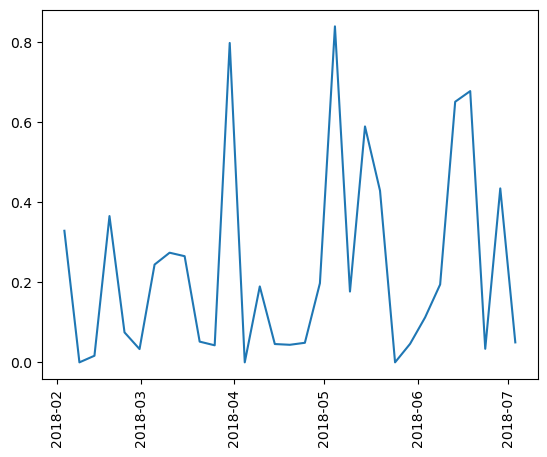

In [16]:
plt.plot(timeseriesB03)
plt.xticks(rotation='vertical')
plt.figsize=(15, 6)
plt.show()

The time serie can be plotted in a similar manner also for the band 08:

#### Displaing cube data for selected band and time step as imageries

We can also display the data for any combination of selected spectral band and time step of the times serie contained in the cube as an imagery. We may need this to check the data visually, over entire area of interest (geographical extent of the cube).
For example we'll select the time step 21.5.2018 and display the data as image for both spectral bands contianed in the cube (B04 RED and B08 NIR).

CHANGE DATES, BANDS and vmin, vmax!

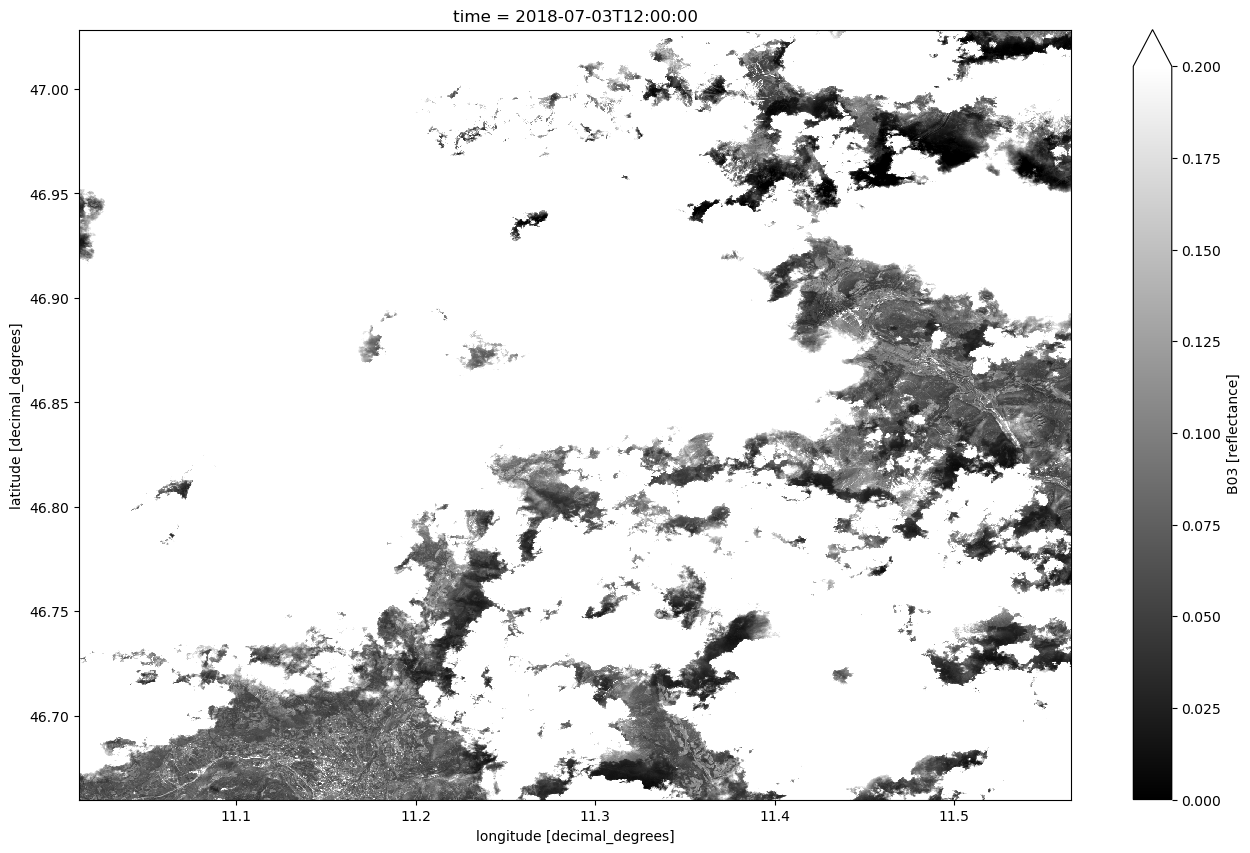

In [17]:
cube.B03.sel(time='2018-07-03 12:00:00', method='nearest').plot.imshow(vmin=0.0, vmax=0.2, cmap='gray', figsize=(16, 10))

#### Displaing statistics for SentinelHub request
Now SentinelHub data requests have been made. We can easilly display statistics on this request. 


In [18]:
request_collector.stats

#### Preparing values for new NDSI layer
Now we will prepare values for the new NDSI layer, based on combination of the bands already contained in our cube.

We are going to compute NDSI indexes from bands B03 and B11 of Sentinel-2 (S2L2A), using following well-know prescription:

Normalized Difference Vegetation Index (NDVI) = (NIR-RED)/(NIR+RED). In our case, Sentinel-2 bandwise speaking, NDVI = (B08-B04)/(B08+B04).


In [19]:
ndsi=(cube.B03-cube.B11)/(cube.B03+cube.B11)

#### Specifying properties of new NDSI layer
We can also specify some properties of the new NDVI layer, which should be added into our cube - in this case, we set the "long name" and units of the layer.


In [20]:
ndsi.attrs['long_name']='Normalized Difference Snow Index'
ndsi.attrs['units']='unitless'

#### Adding a new NDVI layer to cube
Now the values are calculated and the properties specified, we can easilly add the new NDVI layer into our cube.

In [21]:
cube['NDSI']=ndsi

#### Displaying information for NDVI layer
Again, as in case of original bands 04 and 08, we can ceck the properties of the NDVI layer.

In [22]:
cube.NDSI

<xarray.DataArray 'NDSI' (time: 31, lat: 2048, lon: 3072)>
dask.array<truediv, shape=(31, 2048, 3072), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.03 47.03 47.03 47.03 ... 46.66 46.66 46.66 46.66
  * lon      (lon) float64 11.01 11.01 11.01 11.01 ... 11.56 11.56 11.57 11.57
  * time     (time) datetime64[ns] 2018-02-03T12:00:00 ... 2018-07-03T12:00:00
Attributes:
    long_name:  Normalized Difference Snow Index
    units:      unitless

In [23]:
cube

<xarray.Dataset>
Dimensions:    (time: 31, lat: 2048, lon: 3072, bnds: 2)
Coordinates:
  * lat        (lat) float64 47.03 47.03 47.03 47.03 ... 46.66 46.66 46.66 46.66
  * lon        (lon) float64 11.01 11.01 11.01 11.01 ... 11.56 11.56 11.57 11.57
  * time       (time) datetime64[ns] 2018-02-03T12:00:00 ... 2018-07-03T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B02        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CLM        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    NDSI       (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2023-02-07T08:01:44.797917
    time_coverage_start:       2018-02-01T00:00:00+00:00
    time_coverage_end:         2018-07-06T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P5DT0H0M0S
    geospatial_lon_min:        11.012421
    geospatial_lat_min:        46.659805
    geospatial_lon_max:        11.565381
    geospatial_lat_max:        47.028445
    processing_level:          L2A

#### Displayng time serie of NDVI
Also, we can display time serie of values of NDVI band at selected location for all time steps.

For example we'll select the point at latitude=54.40, longitude=10.1
Nearest-neighbor interpolation is used by xcube to find closest satellite pixel at each time step.


In [24]:
timeseriesNDSI = cube.NDSI.sel(lat=46.659805, lon=11.012421, method='nearest').to_series()
timeseriesNDSI

time
2018-02-03 12:00:00    0.346872
2018-02-08 12:00:00   -0.998051
2018-02-13 12:00:00   -0.781003
2018-02-18 12:00:00    0.153239
2018-02-23 12:00:00   -0.490996
2018-02-28 12:00:00   -0.623369
2018-03-05 12:00:00   -0.119610
2018-03-10 12:00:00    0.050490
2018-03-15 12:00:00   -0.139376
2018-03-20 12:00:00   -0.546012
2018-03-25 12:00:00   -0.584593
2018-03-30 12:00:00    0.159319
2018-04-04 12:00:00   -0.999014
2018-04-09 12:00:00    0.100465
2018-04-14 12:00:00   -0.576710
2018-04-19 12:00:00   -0.565131
2018-04-24 12:00:00   -0.527308
2018-04-29 12:00:00    0.071952
2018-05-04 12:00:00    0.399916
2018-05-09 12:00:00   -0.081839
2018-05-14 12:00:00    0.674253
2018-05-19 12:00:00    0.381736
2018-05-24 12:00:00   -0.996454
2018-05-29 12:00:00   -0.385126
2018-06-03 12:00:00   -0.130468
2018-06-08 12:00:00   -0.064260
2018-06-13 12:00:00    0.603206
2018-06-18 12:00:00    0.151242
2018-06-23 12:00:00   -0.659468
2018-06-28 12:00:00    0.368438
2018-07-03 12:00:00   -0.558407
Nam

#### Displayng time serie of NDVI in linear plot
Now, when we computed the NDVI values for each step in the time serie, we can easily display them in linear plot, as in case of original Sentinel-2 bands.


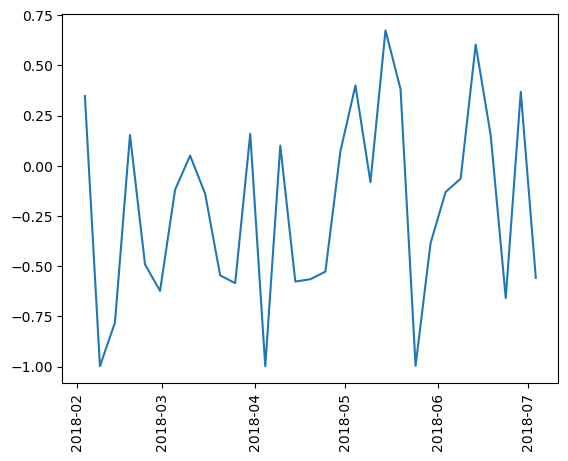

In [26]:
plt.plot(timeseriesNDSI)
plt.xticks(rotation='vertical')
plt.figsize=(15, 6)
plt.show()

Plotting time-series NDVI data produces a temporal curve that summarizes the various stages that green vegetation undergoes during a complete growing season. 
Such curves can be analyzed to extract key phenological variables, or metrics, about a particular season, such as the start, peak and end of the growing season. These characteristics may correspond directly to conventional, ground-based phenological events like growing (the NDVI values grows), mowing, harvesting or ploughing (NDVI values drops rapidly) and provide indications of ecosystem dynamics.

#### Displaying NDVI at selected time step as image

To check the NDVI values over whole area of interest, we can display the NDVI values for any selected time step of the time serie as image in selected color scale. 
For example we'll select the time step 21.5.2018.

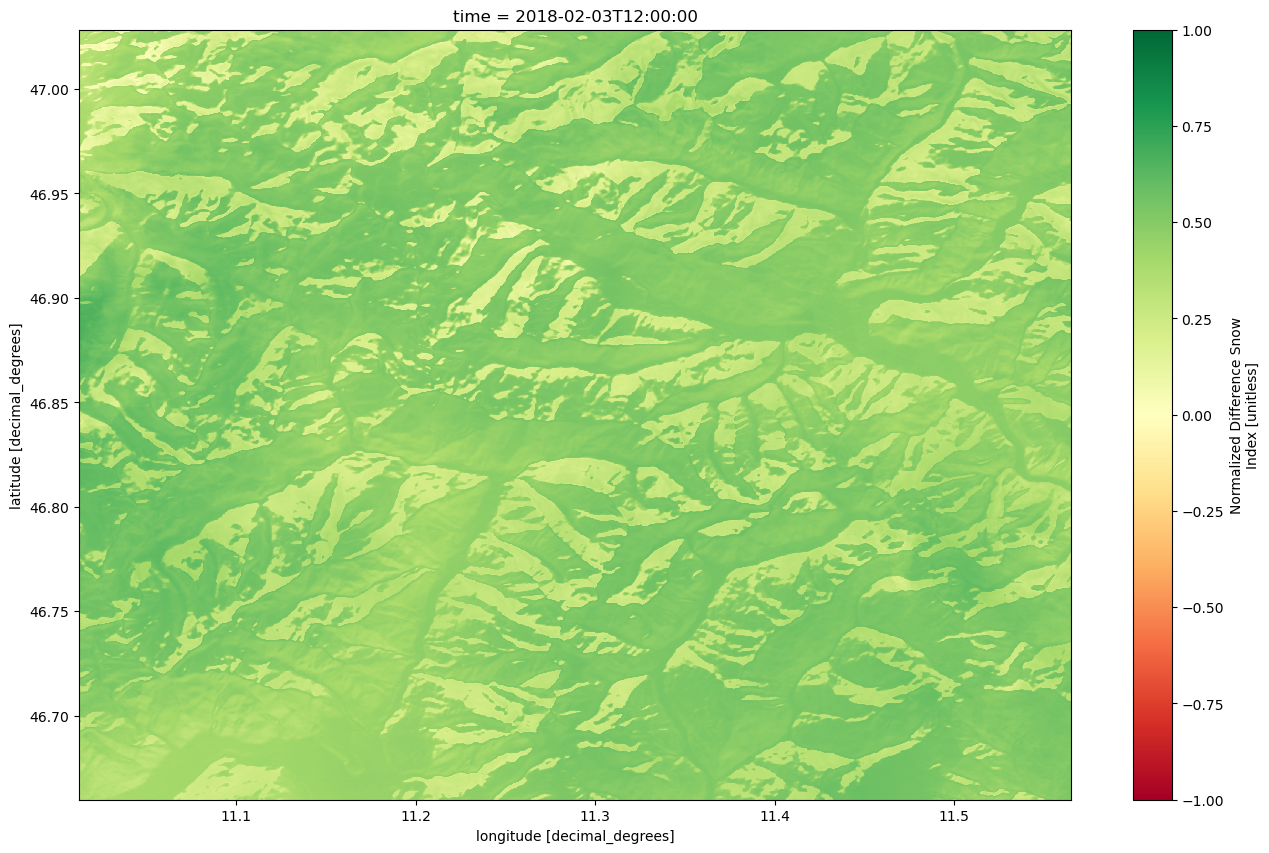

In [30]:
cube.NDSI.sel(time='2018-02-03 10:00:00', method='nearest').plot.imshow(vmin=-1, vmax=1, cmap='RdYlGn', figsize=(16, 10))
#cube.NDSI.sel(time='2018-05-04 10:00:00', method='nearest').plot.imshow(vmin=-1, vmax=1, cmap='RdYlGn', figsize=(16, 10))
#cube.NDSI.sel(time='2018-07-03 10:00:00', method='nearest').plot.imshow(vmin=-1, vmax=1, cmap='RdYlGn', figsize=(16, 10))

#### Displaying NDVI for all time steps in the serie as image

To check the NDVI values over whole area of interest for all time step in the time serie, 
we can display the NDVI values for all selected time steps of the serie as image in the same color scale beside each other. 
This allows us to visually compare the development of NDVI values over whole time serie and to compare various time steps with each other.

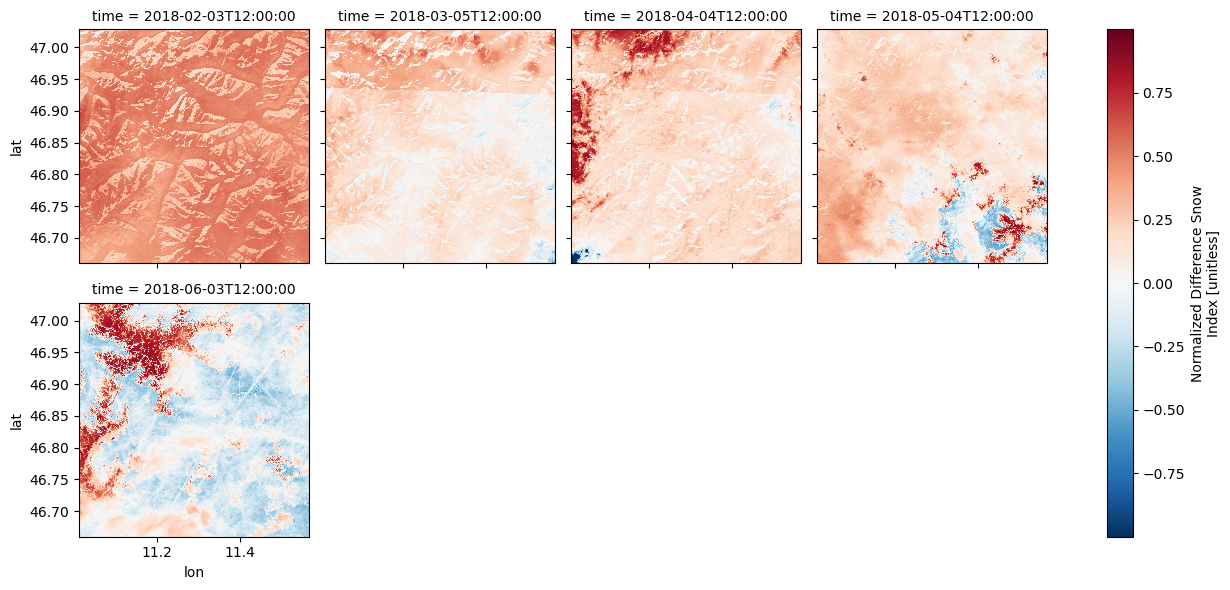

In [31]:
ts_dates = ['2018-02-03 10:00:00', '2018-03-03 10:00:00', '2018-04-03 10:00:00', '2018-05-03 10:00:00', '2018-06-03 10:00:00'] #  how to select via index number?
cube.NDSI.sel(time=ts_dates, method='nearest').plot.imshow(col='time', col_wrap=4)

### Get the Snow Cover Area
- Threshold: snow, no-snow
- https://xcube.readthedocs.io/en/latest/api.html#cube-computation

In [38]:
snow_mask_ndsi = cube.NDSI > 0.4
snow_mask_ndsi # this is a binary mask now

<xarray.DataArray 'NDSI' (time: 31, lat: 2048, lon: 3072)>
dask.array<gt, shape=(31, 2048, 3072), dtype=bool, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.03 47.03 47.03 47.03 ... 46.66 46.66 46.66 46.66
  * lon      (lon) float64 11.01 11.01 11.01 11.01 ... 11.56 11.56 11.57 11.57
  * time     (time) datetime64[ns] 2018-02-03T12:00:00 ... 2018-07-03T12:00:00

In [39]:
snow_mask_red = cube.B04 > 0.2

In [40]:
#snow_mask = np.logical_and(snow_mask_ndsi, snow_mask_red)
snow_mask = snow_mask_ndsi

In [41]:
timeseriesSnow = snow_mask.sel(lat=46.659805, lon=11.012421, method='nearest').to_series()
timeseriesSnow

time
2018-02-03 12:00:00    False
2018-02-08 12:00:00    False
2018-02-13 12:00:00    False
2018-02-18 12:00:00    False
2018-02-23 12:00:00    False
2018-02-28 12:00:00    False
2018-03-05 12:00:00    False
2018-03-10 12:00:00    False
2018-03-15 12:00:00    False
2018-03-20 12:00:00    False
2018-03-25 12:00:00    False
2018-03-30 12:00:00    False
2018-04-04 12:00:00    False
2018-04-09 12:00:00    False
2018-04-14 12:00:00    False
2018-04-19 12:00:00    False
2018-04-24 12:00:00    False
2018-04-29 12:00:00    False
2018-05-04 12:00:00    False
2018-05-09 12:00:00    False
2018-05-14 12:00:00     True
2018-05-19 12:00:00    False
2018-05-24 12:00:00    False
2018-05-29 12:00:00    False
2018-06-03 12:00:00    False
2018-06-08 12:00:00    False
2018-06-13 12:00:00     True
2018-06-18 12:00:00    False
2018-06-23 12:00:00    False
2018-06-28 12:00:00    False
2018-07-03 12:00:00    False
Name: NDSI, dtype: bool

### Cloud Masking
- Cloud masking: snow, no-snow, cloud
- Show ts ndsi, and plot ndsi again
- https://xcube.readthedocs.io/en/latest/api.html#cube-masking
- https://xcube.readthedocs.io/en/latest/api.html#cube-computation

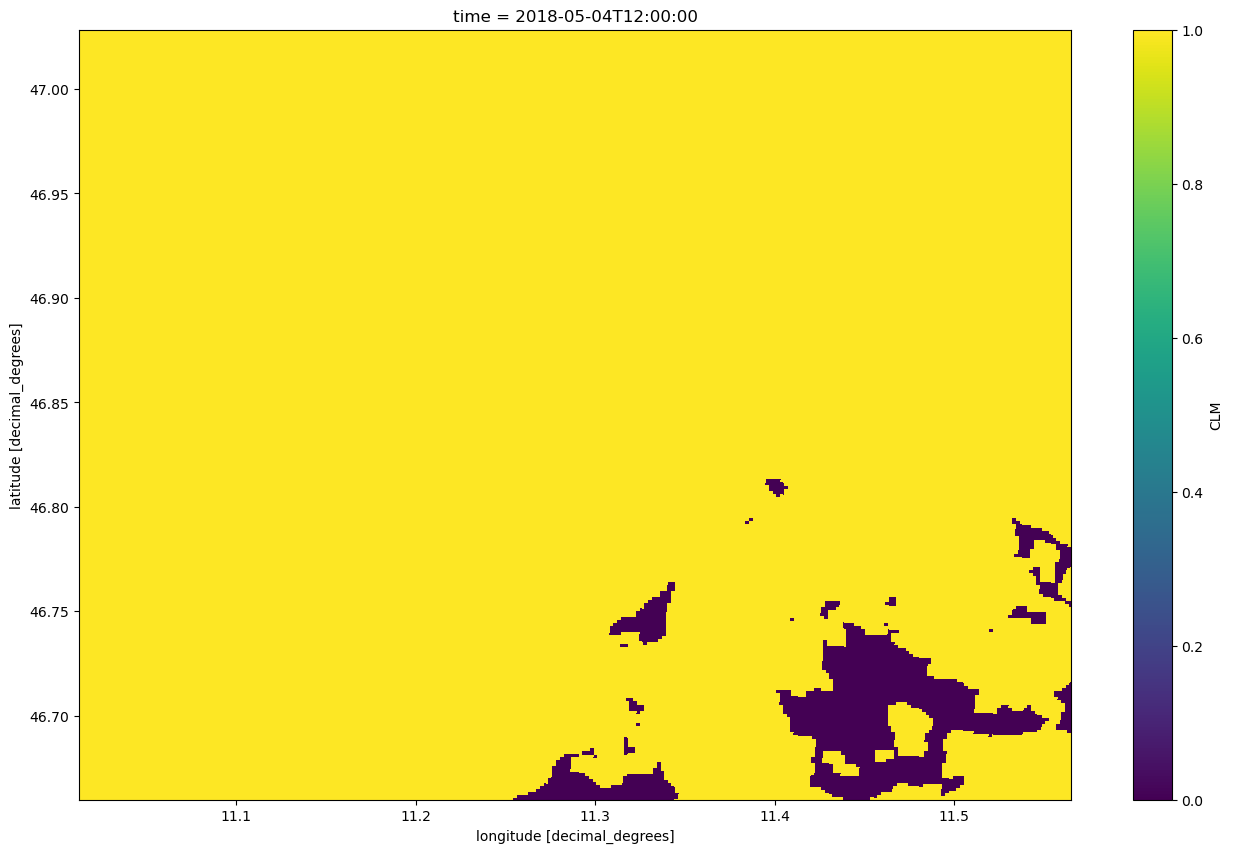

In [42]:
cube.CLM.sel(time='2018-05-04 10:00:00', method='nearest').plot.imshow(figsize=(16, 10)) # check for cloud values, it's 1

In [43]:
# here is the cloud masking happening: snow = 0, no snow = 1, cloud = 2
snow_mask_nocld = snow_mask.where(cube.CLM==0, 2) 

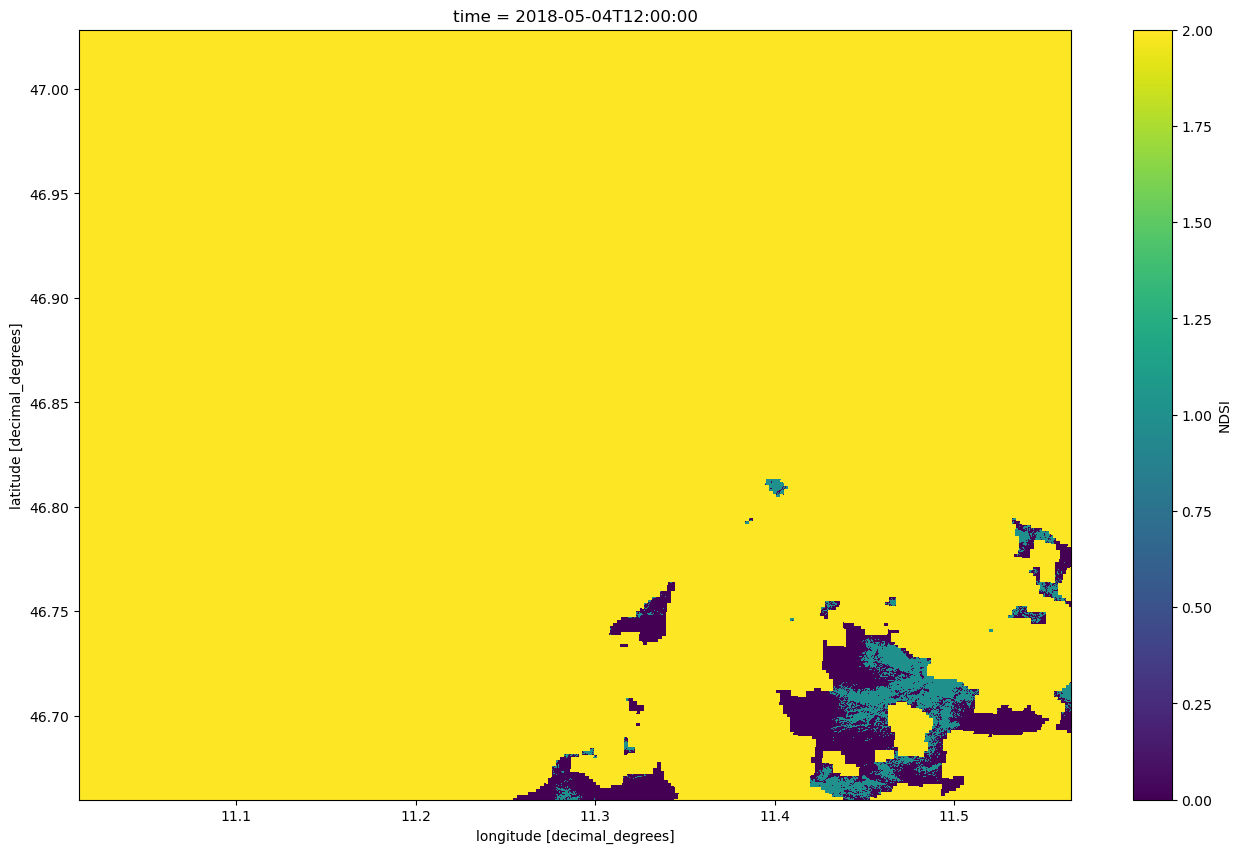

In [44]:
snow_mask_nocld.sel(time='2018-05-04 10:00:00', method='nearest').plot.imshow(figsize=(16, 10))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


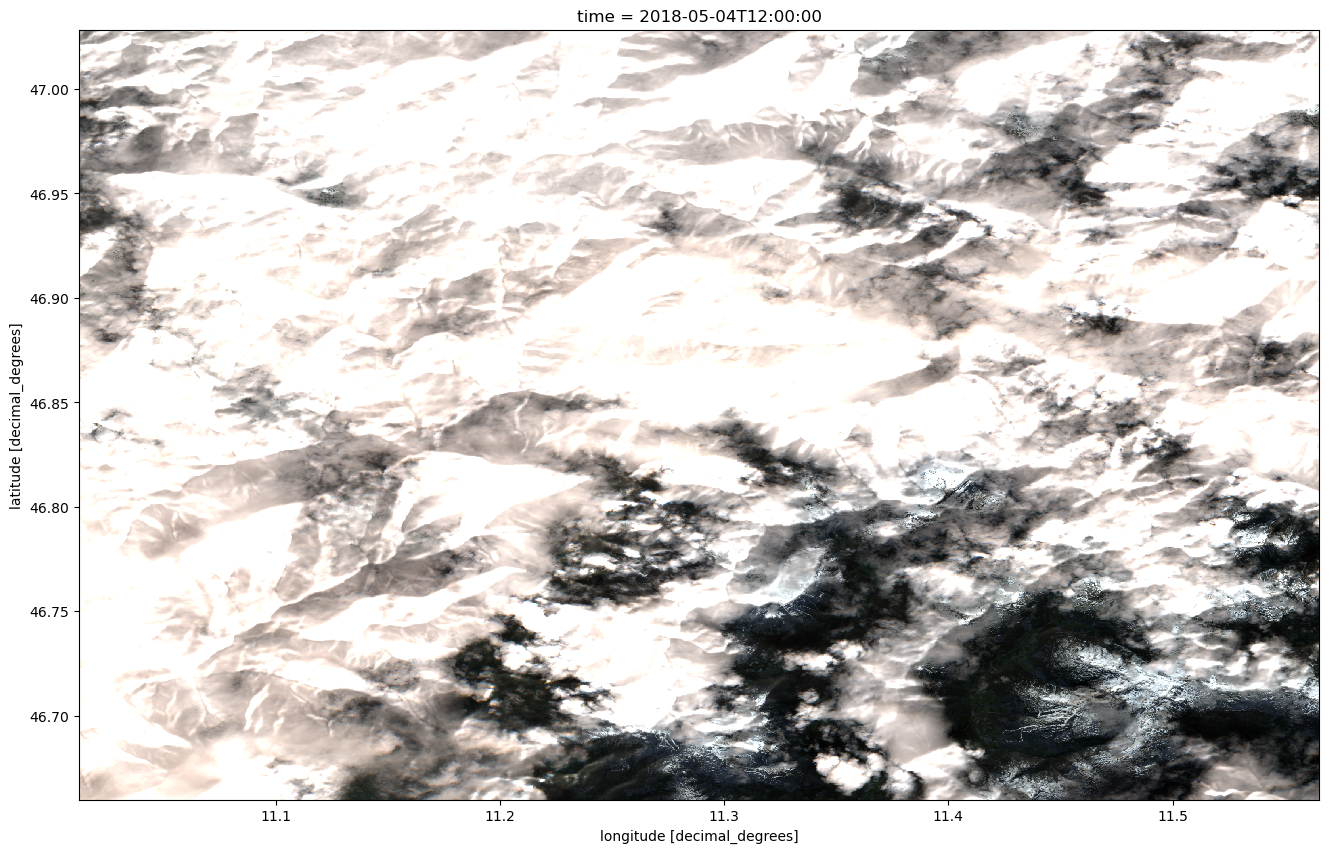

In [64]:
# cube.loc[dict(variable='B02')]
cube.drop(["CLM","B11"]).sel(time='2018-05-04 10:00:00', method='nearest').to_array().plot.imshow(figsize=(16, 10), cmap='brg')

### Aggregate to a Watershed
Aggregate to polygon (add polygon to workspace)
cloud percentage in polygon per time step
remove cloud percentage less than 30%
snow percentage
plot ts of snow percentage
linear interpolation
plot again


1. mask_dataset_by_geometry() -> outside of geometry will be NaN
2. then get the stats over the masked area:
for ndvi_date in NDVI:
    pprint(
        {
            "date": str(ndvi_date.time.values),
            "max": ndvi_date.values.max(),
            "mean": ndvi_date.values.mean(),
            "min": ndvi_date.values.min(),
            "stDev": np.std(ndvi_date.values),
        }
    )

https://xcube.readthedocs.io/en/latest/api.html#cube-computation
https://eurodatacube.com/documentation/calculating-ndvi

In [45]:
catchment = gpd.read_file('ADO_DSC_ITH1_0024.geojson') # this one is drawn by hand 
catchment

geometry
0  POLYGON ((11.17719 46.69906, 11.20603 46.72289...

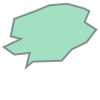

In [46]:
catchment_shapely = catchment.loc[0].geometry # only keep geometry as shapely object
catchment_shapely

In [47]:
snow_mask_nocld

<xarray.DataArray 'NDSI' (time: 31, lat: 2048, lon: 3072)>
dask.array<where, shape=(31, 2048, 3072), dtype=int64, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.03 47.03 47.03 47.03 ... 46.66 46.66 46.66 46.66
  * lon      (lon) float64 11.01 11.01 11.01 11.01 ... 11.56 11.56 11.57 11.57
  * time     (time) datetime64[ns] 2018-02-03T12:00:00 ... 2018-07-03T12:00:00

In [25]:
snow_mask_nocld.to_dataset(name="snow_mask")

<xarray.Dataset>
Dimensions:    (lat: 2048, lon: 3072, time: 31)
Coordinates:
  * lat        (lat) float64 47.03 47.03 47.03 47.03 ... 46.66 46.66 46.66 46.66
  * lon        (lon) float64 11.01 11.01 11.01 11.01 ... 11.56 11.56 11.57 11.57
  * time       (time) datetime64[ns] 2018-02-03T12:00:00 ... 2018-07-03T12:00:00
Data variables:
    snow_mask  (time, lat, lon) int64 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

In [48]:
# masking with the polygon
snow_mask_nocld_catch = mask_dataset_by_geometry(snow_mask_nocld.to_dataset(name="snow_mask"), catchment_shapely)
snow_mask_nocld_catch

<xarray.Dataset>
Dimensions:    (lat: 1486, lon: 2163, time: 31)
Coordinates:
  * lat        (lat) float64 46.97 46.97 46.97 46.97 ... 46.7 46.7 46.7 46.7
  * lon        (lon) float64 11.08 11.08 11.08 11.08 ... 11.47 11.47 11.47 11.47
  * time       (time) datetime64[ns] 2018-02-03T12:00:00 ... 2018-07-03T12:00:00
Data variables:
    snow_mask  (time, lat, lon) float64 dask.array<chunksize=(1, 169, 121), meta=np.ndarray>
Attributes:
    geospatial_lon_min:         11.082801
    geospatial_lon_max:         11.472141
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.00018000000000000017
    geospatial_lat_min:         46.699225
    geospatial_lat_max:         46.966705
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.00017999999999999917
    date_modified:              2023-02-07T08:18:07.837800

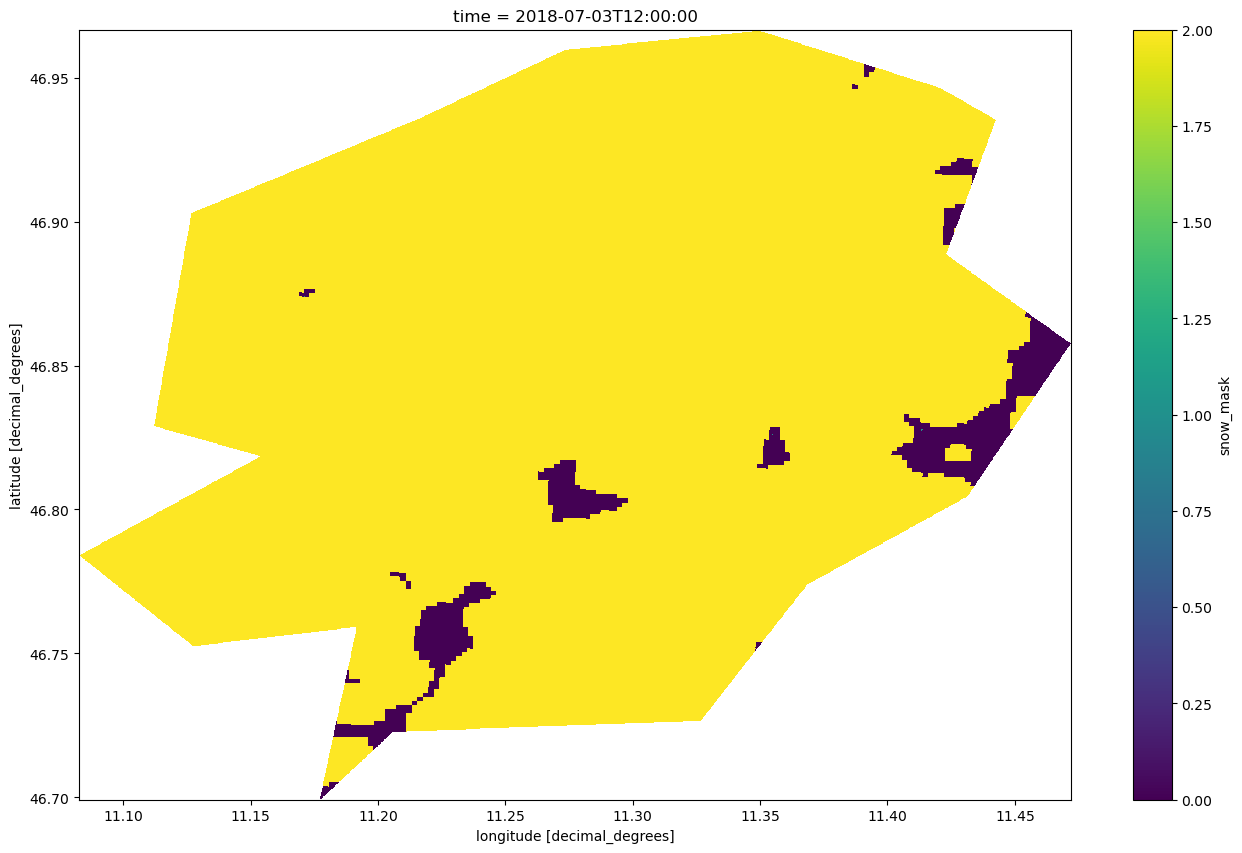

In [49]:
snow_mask_nocld_catch.snow_mask.sel(time='2018-07-04 10:00:00', method='nearest').plot.imshow(figsize=(16, 10))

In [49]:
snow_mask_nocld_catch

<xarray.Dataset>
Dimensions:    (lat: 1486, lon: 2163, time: 31)
Coordinates:
  * lat        (lat) float64 46.97 46.97 46.97 46.97 ... 46.7 46.7 46.7 46.7
  * lon        (lon) float64 11.08 11.08 11.08 11.08 ... 11.47 11.47 11.47 11.47
  * time       (time) datetime64[ns] 2018-02-03T12:00:00 ... 2018-07-03T12:00:00
Data variables:
    snow_mask  (time, lat, lon) float64 dask.array<chunksize=(1, 169, 121), meta=np.ndarray>
Attributes:
    geospatial_lon_min:         11.082801
    geospatial_lon_max:         11.472141
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.00018000000000000017
    geospatial_lat_min:         46.699225
    geospatial_lat_max:         46.966705
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.00017999999999999917
    date_modified:              2023-02-07T06:21:31.464745

In [50]:
def cloud_percent(x):
    valid_pixels = np.sum(~np.isnan(x))
    cloudy_pixels = np.sum(x==2)
    return cloudy_pixels/valid_pixels*100

def snow_percent(x):
    snow_pixels = np.sum(x==1)
    nosnow_pixels = np.sum(x==0)
    return snow_pixels/(snow_pixels + nosnow_pixels) * 100

In [51]:
cloud_percent = snow_mask_nocld_catch.snow_mask.groupby('time').apply(cloud_percent)
snow_percent = snow_mask_nocld_catch.snow_mask.groupby('time').apply(snow_percent)

In [52]:
df = pd.DataFrame({'cloud_percent': cloud_percent.to_series(), 'snow_percent': snow_percent.to_series()})
df

/opt/conda/envs/edc-default-2022.10-14/lib/python3.9/site-packages/dask/array/core.py:4893: RuntimeWarning: invalid value encountered in long_scalars
  result = function(*args, **kwargs)


cloud_percent  snow_percent
time                                            
2018-02-03 12:00:00     100.000000           NaN
2018-02-08 12:00:00      22.631711     72.966661
2018-02-13 12:00:00      35.828646     70.918625
2018-02-18 12:00:00      48.439455     67.344149
2018-02-23 12:00:00      89.034826     75.329668
2018-02-28 12:00:00       3.021602     70.345615
2018-03-05 12:00:00     100.000000           NaN
2018-03-10 12:00:00     100.000000           NaN
2018-03-15 12:00:00     100.000000           NaN
2018-03-20 12:00:00      21.974283     74.947073
2018-03-25 12:00:00       3.442337     67.998822
2018-03-30 12:00:00     100.000000           NaN
2018-04-04 12:00:00     100.000000           NaN
2018-04-09 12:00:00      97.555961     94.123413
2018-04-14 12:00:00      13.207689     70.966100
2018-04-19 12:00:00       0.000000     53.037529
2018-04-24 12:00:00      14.018733     41.267740
2018-04-29 12:00:00     100.000000           NaN
2018-05-04 12:00:00      99.177998     16.009425
2018-05-09 12:00:00      93.294170     57.223856
2018-05-14 12:00:00      99.683340     33.542572
2018-05-19 12:00:00     100.000000           NaN
2018-05-24 12:00:00     100.000000           NaN
2018-05-29 12:00:00      99.985882      0.000000
2018-06-03 12:00:00      94.873038     31.076715
2018-06-08 12:00:00      99.624880      0.000000
2018-06-13 12:00:00     100.000000           NaN
2018-06-18 12:00:00      82.696368      0.937839
2018-06-23 12:00:00       6.354767      1.143654
2018-06-28 12:00:00     100.000000           NaN
2018-07-03 12:00:00      96.096561      0.028726

<AxesSubplot: xlabel='time'>

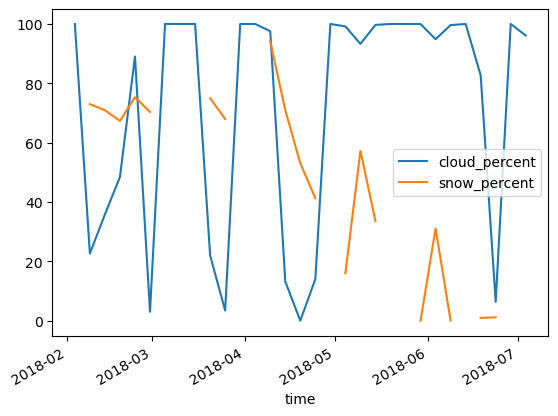

In [53]:
df.plot()

In [54]:
df_cloudfree = df.loc[df['cloud_percent'] < 20, :]
df_cloudfree

cloud_percent  snow_percent
time                                            
2018-02-28 12:00:00       3.021602     70.345615
2018-03-25 12:00:00       3.442337     67.998822
2018-04-14 12:00:00      13.207689     70.966100
2018-04-19 12:00:00       0.000000     53.037529
2018-04-24 12:00:00      14.018733     41.267740
2018-06-23 12:00:00       6.354767      1.143654

<AxesSubplot: xlabel='time'>

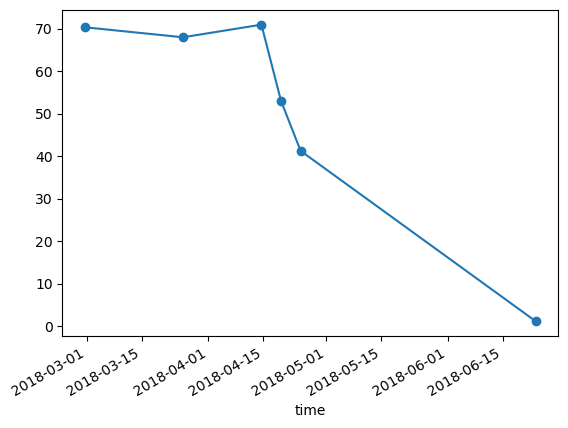

In [55]:
df_cloudfree['snow_percent'].plot(marker='o')

### Compare the evolution of SCA to runoff
load runoff of passeier station(s) --> would be cool to have it as geojson available, point and measurement in one file
plot together with snowcover percentage

In [115]:
headers = ['time', 'dsc_m3_s']
date_col = ['time']
dsc = pd.read_csv('ADO_DSC_ITH1_0024.csv', sep='\t', header=0, names=headers, parse_dates=date_col)

In [68]:
dsc = pd.read_csv('ADO_DSC_ITH1_0025.csv', sep=',', index_col='Time', parse_dates=True)

In [69]:
dsc

discharge_m3_s
Time                               
1994-01-01 01:00:00            4.03
1994-01-02 01:00:00            3.84
1994-01-03 01:00:00            3.74
1994-01-04 01:00:00            3.89
1994-01-05 01:00:00            3.80
...                             ...
2021-07-17 02:00:00             NaN
2021-07-18 02:00:00             NaN
2021-07-19 02:00:00             NaN
2021-07-20 02:00:00             NaN
2021-07-21 02:00:00             NaN

[10064 rows x 1 columns]

<AxesSubplot: xlabel='Time'>

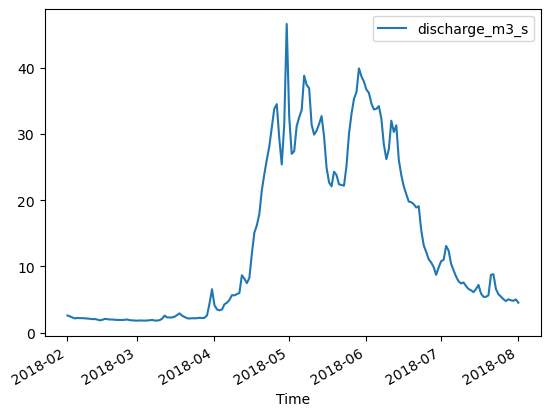

In [71]:
# select according date range
dsc.loc['2018-02-01':'2018-08-01'].plot()

In [ ]:
# plot the two timeseries
